# YIELD PREDICTION 
Data : All dataset(publicly available dataset) here are taken form [FAO (Food and Agriculture Organization)](http://www.fao.org/home/en/) and [World Data Bank](https://data.worldbank.org/).
### Summary:
* Importing and assembling data set.
* Exploratory analysis
* Models propositions:
    * Linear Regression.
    * XGBoosting
    * Random Forest 
    * Gradient Boosting 
    * Decision Tree
    * Bagging Regressor
    * Support Vector Regression
* Hyperparameter tuning.
* Model retained and conclusions.

# Importing and assembling data set

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

dataset/yield_df.csv
dataset/yield.csv
dataset/pesticides.csv
dataset/rainfall.csv
dataset/temp.csv


While this notebook has the intention of been and excercise / review / first steps for our final ML project. I use the 4 original files to do my own Data-frame.

Taking acount that the files containing the information about pesticides, rainfall and temperatures are linked to a geographic zone, we're going to try to create a unique DF containing all the data attached to a geographic zone and a year.

### Working in yield

In [3]:
df_yield = pd.read_csv(dirname + "/" + filenames[1])
df_yield.head()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value
0,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1961,1961,hg/ha,14000
1,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1962,1962,hg/ha,14000
2,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1963,1963,hg/ha,14260
3,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1964,1964,hg/ha,14257
4,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1965,1965,hg/ha,14400


We analyse the information inside the 'yield' dataframe, and than select those attributs of interest

In [4]:
df_yield.Domain.describe() # unique = 1 this coloumn isn't giving us new information, we can eliminate it.
df_yield['Domain Code'].describe()# unique = 1 this coloumn isn't giving us new information, we can eliminate it.
tmp = np.where(df_yield['Year Code'] != df_yield['Year']) # This 2 columns have exactly the same info.
df_yield['Unit'].describe() # unique = 1 this coloumn isn't giving us new information, we can eliminate it.
df_yield['Element'].describe() # unique = 1 this coloumn isn't giving us new information, we can eliminate it.
df_yield['Area'].describe() #212 countries

# So, we create the new dataset putting only the meaningful data we found.
df = df_yield.loc[:,['Area','Item','Year','Value']]
df.shape

(56717, 4)

### Working in temp

In [5]:
df_temp = pd.read_csv(dirname + "/" + filenames[4])
df_temp.columns = df_temp.columns.str.replace('year', 'Year')
df_temp.columns = df_temp.columns.str.replace('country', 'Area')
df_temp.head()

,Year,Area,avg_temp
0,1849,Côte D'Ivoire,25.58
1,1850,Côte D'Ivoire,25.52
2,1851,Côte D'Ivoire,25.67
3,1852,Côte D'Ivoire,NaN
4,1853,Côte D'Ivoire,NaN


Here we merge 'yield' and 'temp' datasets. The primary key used to do so is an ensemble 'Year' and 'Area'

In [6]:
# merging both data frames by Year and Area
df = pd.merge(df, df_temp, how='inner', on = ['Year', 'Area'])
df.columns = df.columns.str.replace('Value', "yield_hg/ha")
df

,Area,Item,Year,yield_hg/ha,avg_temp
0,Afghanistan,Maize,1961,14000,14.23
1,Afghanistan,Potatoes,1961,86667,14.23
2,Afghanistan,"Rice, paddy",1961,15190,14.23
3,Afghanistan,Wheat,1961,10220,14.23
4,Afghanistan,Maize,1962,14000,14.10
...,...,...,...,...,...
84854,Zimbabwe,"Rice, paddy",2013,22581,19.76
84855,Zimbabwe,Sorghum,2013,3066,19.76
84856,Zimbabwe,Soybeans,2013,13142,19.76
84857,Zimbabwe,Sweet potatoes,2013,22222,19.76


In [7]:
print(df.isna().sum())
# I confirmed there's not NaNs ! In this case we apparently have a super good quality dataset.

Area           0
Item           0
Year           0
yield_hg/ha    0
avg_temp       0
dtype: int64


### Working in rainfall

In [8]:
df_rainfall = pd.read_csv(dirname + "/" + filenames[3])
df_rainfall.columns = df_rainfall.columns.str.replace('average_rain_fall_mm_per_year', 'rain_mm_year')
df_rainfall.columns = df_rainfall.columns.str.replace(' Area', 'Area')
df_rainfall

,Area,Year,rain_mm_year
0,Afghanistan,1985,327
1,Afghanistan,1986,327
2,Afghanistan,1987,327
3,Afghanistan,1989,327
4,Afghanistan,1990,327
...,...,...,...
6722,Zimbabwe,2013,657
6723,Zimbabwe,2014,657
6724,Zimbabwe,2015,657
6725,Zimbabwe,2016,657


Merging the 'rainfall' information into the dataframe we had so far

In [9]:
df = pd.merge(df, df_rainfall, how='inner', on = ['Year', 'Area'])
df

,Area,Item,Year,yield_hg/ha,avg_temp,rain_mm_year
0,Afghanistan,Maize,1985,16652,15.52,327
1,Afghanistan,Potatoes,1985,140909,15.52,327
2,Afghanistan,"Rice, paddy",1985,22482,15.52,327
3,Afghanistan,Wheat,1985,12277,15.52,327
4,Afghanistan,Maize,1986,16875,14.71,327
...,...,...,...,...,...,...
44130,Zimbabwe,"Rice, paddy",2013,22581,19.76,657
44131,Zimbabwe,Sorghum,2013,3066,19.76,657
44132,Zimbabwe,Soybeans,2013,13142,19.76,657
44133,Zimbabwe,Sweet potatoes,2013,22222,19.76,657


In [10]:
print(df.isna().sum())

Area            0
Item            0
Year            0
yield_hg/ha     0
avg_temp        0
rain_mm_year    0
dtype: int64


### Working in pesticides

In [11]:
df_pesticides = pd.read_csv(dirname + "/" + filenames[2])
df_pesticides.head()


,Domain,Area,Element,Item,Year,Unit,Value
0,Pesticides Use,Albania,Use,Pesticides (total),1990,tonnes of active ingredients,121.0
1,Pesticides Use,Albania,Use,Pesticides (total),1991,tonnes of active ingredients,121.0
2,Pesticides Use,Albania,Use,Pesticides (total),1992,tonnes of active ingredients,121.0
3,Pesticides Use,Albania,Use,Pesticides (total),1993,tonnes of active ingredients,121.0
4,Pesticides Use,Albania,Use,Pesticides (total),1994,tonnes of active ingredients,201.0


In [12]:
df_pesticides.Item.describe() # unique = 1 this coloumn isn't giving us new information, we can eliminate it.
df_pesticides.Element.describe() # unique = 1 this coloumn isn't giving us new information, we can eliminate it.
df_pesticides.Domain.describe() # unique = 1 this coloumn isn't giving us new information, we can eliminate it.
df_pesticides.Unit.describe() # unique = 1 this coloumn isn't giving us new information, we can eliminate it.
df_pesticides.columns = df_pesticides.columns.str.replace('Value', 'ton_pest')


After selecting the attributs of interest we merge this data frame with the previous one

In [13]:
df = pd.merge(df, df_pesticides.loc[:,['Area', 'Year', 'ton_pest']], how='inner', on = ['Year', 'Area'])
print(df.isna().sum())
df  # So far we have no NA's in our data set

Area            0
Item            0
Year            0
yield_hg/ha     0
avg_temp        0
rain_mm_year    0
ton_pest        0
dtype: int64


,Area,Item,Year,yield_hg/ha,avg_temp,rain_mm_year,ton_pest
0,Albania,Maize,1990,36613,16.37,1485,121.00
1,Albania,Potatoes,1990,66667,16.37,1485,121.00
2,Albania,"Rice, paddy",1990,23333,16.37,1485,121.00
3,Albania,Sorghum,1990,12500,16.37,1485,121.00
4,Albania,Soybeans,1990,7000,16.37,1485,121.00
...,...,...,...,...,...,...,...
28243,Zimbabwe,"Rice, paddy",2013,22581,19.76,657,2550.07
28244,Zimbabwe,Sorghum,2013,3066,19.76,657,2550.07
28245,Zimbabwe,Soybeans,2013,13142,19.76,657,2550.07
28246,Zimbabwe,Sweet potatoes,2013,22222,19.76,657,2550.07


At this point we have a complete data set, the ideal now is to explore this dataset using some exploratory statistics techniques to understand the dependences, correlations and patterns between attributs.

## cleaning dataset

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28248 entries, 0 to 28247
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Area          28248 non-null  object 
 1   Item          28248 non-null  object 
 2   Year          28248 non-null  int64  
 3   yield_hg/ha   28248 non-null  int64  
 4   avg_temp      28248 non-null  float64
 5   rain_mm_year  28248 non-null  object 
 6   ton_pest      28248 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 1.5+ MB


We notice that 'rain_mm_year' is a data of type 'object' when it should be of a numeric type. After some investigation, it's possible to see that there were some values in this column that were no valid information, represented by two dots. We drop these values out and keep the new DF with 'rain_mm_year' as a float data

In [15]:
# We have just to correct the dataType of rain_mm_year
# There is something that we can't not convert in float, to find it we used an easy approach with a for cycle and a try-except control structure.
for raindata in df.rain_mm_year:
    try:
        raindata = float(raindata)
    except:
        print(raindata)
        
tmp = np.where(df.rain_mm_year == '..')
df = df.drop(list(tmp[0]))
# Now we can do the correct dataType to the attribute

df.rain_mm_year = df.rain_mm_year.astype('float')
df.info()

..
..
..
..
..
..
<class 'pandas.core.frame.DataFrame'>
Index: 28242 entries, 0 to 28247
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Area          28242 non-null  object 
 1   Item          28242 non-null  object 
 2   Year          28242 non-null  int64  
 3   yield_hg/ha   28242 non-null  int64  
 4   avg_temp      28242 non-null  float64
 5   rain_mm_year  28242 non-null  float64
 6   ton_pest      28242 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.7+ MB


# Exploratory analyses

In [16]:
df.Year = df.Year.astype('object')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
yield_hg/ha,28242.0,77053.332094,84956.612897,50.00,19919.2500,38295.00,104676.75,501412.00
avg_temp,28242.0,20.542627,6.312051,1.30,16.7025,21.51,26.00,30.65
rain_mm_year,28242.0,1149.055980,709.812150,51.00,593.0000,1083.00,1668.00,3240.00
ton_pest,28242.0,37076.909344,59958.784665,0.04,1702.0000,17529.44,48687.88,367778.00


In [17]:
df.describe(include = 'object').T

,count,unique,top,freq
Area,28242,101,India,4048
Item,28242,10,Potatoes,4276
Year,28242,23,2012,1260


## Normalization

In this section we perform a normalization in the yield value (```yield_hg/ha```). We do so because these values come from heterogeneous cultures, that have differents weights.

The normalization allows un to compare these values of production, even between different plants.

The normalization we perform here is based in the amplitude of production of a given vegetable, therefore the normalization is made **by culture**. This specifc approach by amplitude is called ```Min-Max Normalization```, and can be mathmatically expressed as follow:
$$
y_{\text{norm}} = \frac{y - min}{max - min}
$$

In [18]:
cultures = df.Item.unique()
# take the min and max values for each culture of plants
maxmin_cultures = {culture:(df.loc[df['Item'] == culture, 'yield_hg/ha'].max(), df.loc[df['Item'] == culture, 'yield_hg/ha'].min()) for culture in cultures}

# apply the min-max normalization
yield_norm = []
for ligne in df.iterrows():
    l = ligne[1]
    n = (l['yield_hg/ha'] - maxmin_cultures[l.Item][1])/(maxmin_cultures[l.Item][0] - maxmin_cultures[l.Item][1])
    yield_norm.append(n)

# add the normalized yield values in the data frame
df['yield_norm'] = yield_norm

In [19]:
df.info()
# new data frame, with normalized yield values

<class 'pandas.core.frame.DataFrame'>
Index: 28242 entries, 0 to 28247
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Area          28242 non-null  object 
 1   Item          28242 non-null  object 
 2   Year          28242 non-null  object 
 3   yield_hg/ha   28242 non-null  int64  
 4   avg_temp      28242 non-null  float64
 5   rain_mm_year  28242 non-null  float64
 6   ton_pest      28242 non-null  float64
 7   yield_norm    28242 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 1.9+ MB


## Linear correlation between attributs

In order to capture the correlation between all the attributs we have to encode those that are 'objects' to a numeric value. We'll do so using a label enconder, from the sklearn package

In [20]:
from sklearn.preprocessing import LabelEncoder

df2 = df.copy()
labelencoder = LabelEncoder()
# encoding 'Area' (countries)
df2.iloc[:, 0] = labelencoder.fit_transform(df2.iloc[:, 0]) 
# encoding 'Item' (cultures)
df2.iloc[:, 1] = labelencoder.fit_transform(df2.iloc[:, 1]) 
df2

,Area,Item,Year,yield_hg/ha,avg_temp,rain_mm_year,ton_pest,yield_norm
0,0,1,1990,36613,16.37,1485.0,121.00,0.173018
1,0,3,1990,66667,16.37,1485.0,121.00,0.118175
2,0,4,1990,23333,16.37,1485.0,121.00,0.209099
3,0,5,1990,12500,16.37,1485.0,121.00,0.058037
4,0,6,1990,7000,16.37,1485.0,121.00,0.167232
...,...,...,...,...,...,...,...,...
28243,100,4,2013,22581,19.76,657.0,2550.07,0.201716
28244,100,5,2013,3066,19.76,657.0,2550.07,0.012112
28245,100,6,2013,13142,19.76,657.0,2550.07,0.315022
28246,100,7,2013,22222,19.76,657.0,2550.07,0.034312


                  Area      Year      Item  yield_hg/ha  avg_temp  \
Area          1.000000  0.003421  0.003169     0.006672 -0.045739   
Year          0.003421  1.000000  0.001465     0.091630  0.014409   
Item          0.003169  0.001465  1.000000    -0.225103 -0.078257   
yield_hg/ha   0.006672  0.091630 -0.225103     1.000000 -0.114777   
avg_temp     -0.045739  0.014409 -0.078257    -0.114777  1.000000   
rain_mm_year -0.233549 -0.003798 -0.062580     0.000962  0.313040   
ton_pest     -0.313573  0.140930  0.048070     0.064085  0.030946   
yield_norm    0.008878  0.144001  0.066726     0.627601 -0.293421   

              rain_mm_year  ton_pest  yield_norm  
Area             -0.233549 -0.313573    0.008878  
Year             -0.003798  0.140930    0.144001  
Item             -0.062580  0.048070    0.066726  
yield_hg/ha       0.000962  0.064085    0.627601  
avg_temp          0.313040  0.030946   -0.293421  
rain_mm_year      1.000000  0.180984   -0.052482  
ton_pest          0.1

<Axes: >

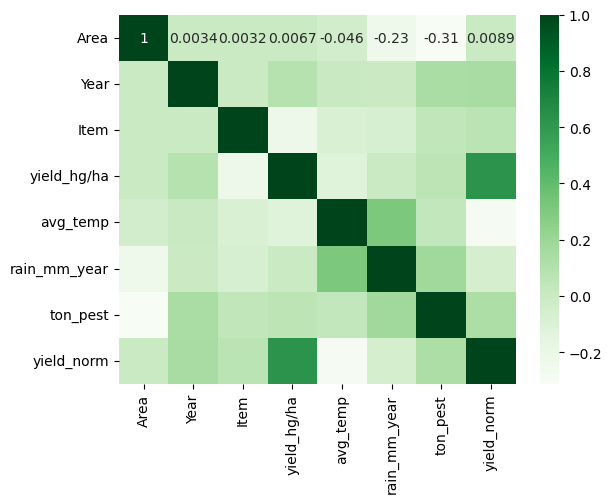

In [21]:
# calculate correlation and plot 
corr_matrix = df2.loc[:,['Area', 'Year', 'Item', 'yield_hg/ha','avg_temp','rain_mm_year', 'ton_pest', 'yield_norm']].corr()
print(corr_matrix)
sns.heatmap(corr_matrix, annot=True, cmap='Greens')

Some remarkable correlations are between the amount of pesticide and the country ('ton_pest', 'Area'); the correlation between rainfall and temperature ('rain_mm_year', 'avg_temp'); and between the rainfall and the amount of pesticides ('ton_pest', 'rain_mm_year')

## Graphique


<Axes: xlabel='Year'>

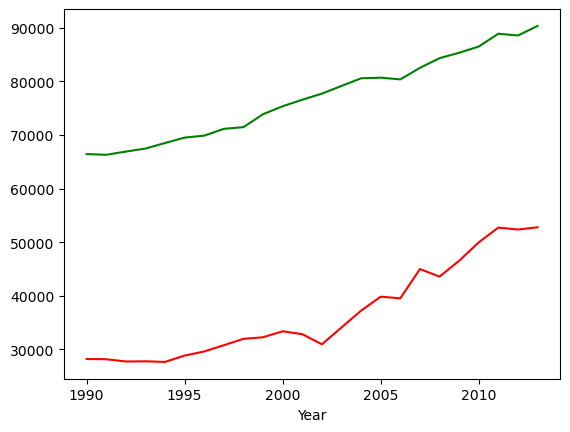

In [22]:
count_crops = df.groupby('Year')['yield_hg/ha'].mean()
count_crops.plot(color='green')

count_crops = df.groupby('Year')['ton_pest'].mean()
count_crops.plot(color='red')

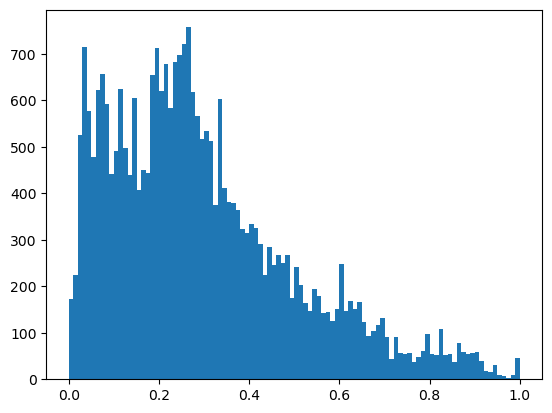

In [23]:
plt.hist(df['yield_norm'], bins=100)
plt.show()

# Model propositions

In this section some models will be proposed in order to predict yield values. As the values we are trying to predict are continuous, the models will be used to perform a regression.

In [24]:
df_mod = df.copy()
df_mod

,Area,Item,Year,yield_hg/ha,avg_temp,rain_mm_year,ton_pest,yield_norm
0,Albania,Maize,1990,36613,16.37,1485.0,121.00,0.173018
1,Albania,Potatoes,1990,66667,16.37,1485.0,121.00,0.118175
2,Albania,"Rice, paddy",1990,23333,16.37,1485.0,121.00,0.209099
3,Albania,Sorghum,1990,12500,16.37,1485.0,121.00,0.058037
4,Albania,Soybeans,1990,7000,16.37,1485.0,121.00,0.167232
...,...,...,...,...,...,...,...,...
28243,Zimbabwe,"Rice, paddy",2013,22581,19.76,657.0,2550.07,0.201716
28244,Zimbabwe,Sorghum,2013,3066,19.76,657.0,2550.07,0.012112
28245,Zimbabwe,Soybeans,2013,13142,19.76,657.0,2550.07,0.315022
28246,Zimbabwe,Sweet potatoes,2013,22222,19.76,657.0,2550.07,0.034312


We're not considering the feature ```Year``` since we have the goal of predicting futures values of yield production.

In [25]:
numeric_attributs = ['avg_temp', 'rain_mm_year', 'ton_pest']
categorical_attributs = ['Area', 'Item']

From this point, we're proposing some tests on the data preprocessing in order to evaluate their effect on the accuracy of the regresion model.

We propose to fit models using four heterogeneos data sets: 
* one with categorical values encoded by ```LabelEncoder()``` in the ```X``` data frame, and the ```y``` data frame with **non normalized** yield values; 
* the second data set will have the same encoding, but the ```y``` values **normalized**; 
* the third will have the categorical values encoded with ```One Hot Encoding``` and **non normalized** yield production values; 
* the last one will have the same encoding as the third one, but now the ```y``` data frame will be **normalized**.

All the values in the feature's data frame (```X```) will be normalized using ```MinMaxScaler()```

In [26]:
# definig features and labels data frames

# selecting the attributs data frame
featuresX = df_mod[numeric_attributs + categorical_attributs]

# selecting labels' data frame
y_Nnorm = df_mod['yield_hg/ha'] # Nnorm means "Non normalized"
y_norm = df_mod['yield_norm'] # norm are "normalized" values

In [27]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler


# enconding categorical values
# encoding with LabelEncoder()
X_le = featuresX.copy() # X_le means X encoded with label encoder
label_encoder = LabelEncoder()
for column in categorical_attributs:
    X_le[column] = label_encoder.fit_transform(featuresX[column])

# encoding with One Hot encoding
X_oh = pd.get_dummies(featuresX, columns=['Area',"Item"]) # X_oh means X encoded with One Hot

# normalizing both feature's data frame with min-max normalization
scaler = MinMaxScaler()
X_le = scaler.fit_transform(X_le)
X_oh = scaler.fit_transform(X_oh)

In [28]:
# assembling data sets in a dictionary makes the work easier
data_sets = {'one hot, non norm': [X_oh, y_Nnorm], 'one hot, norm': [X_oh, y_norm], 'label enc, non norm': [X_le, y_Nnorm], 'label enc, norm': [X_le, y_norm]}

In [29]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

# function to calculate the performance of the model with cross validation
def fitPredict_score(model, dic_data_sets):
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    scoring = ['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']
    scores = cross_validate(model, dic_data_sets[0], dic_data_sets[1],
                            cv=cv, scoring=scoring)
    return scores

# create data frame where theses values of performance will be stored
final_results = pd.DataFrame(columns=['type', 'model', 'r2', 'rmse', 'mae'])

```R2``` is a goodness-of-fit measure for linear regression models. This statistic indicates the percentage of the variance in the dependent variable that the independent variables explain collectively. Also, in scikit-learn the method ```score()```, when used with regression models, returns the ```R2``` value as a mesure to the quality of the model. It's considered as the accuracy of a regression model. That's why this will be our main reference to select a good model.

Besides the ```R2``` we also calculate ```RMSE``` (root mean square error) and ```MAE``` (mean absolute error). Althoutght these are good mesures to evaluate the performance of a regression model, it's more problematic in our case for two reasons: first because we are trying differents data sets, one where ```y``` (yield) is normalized and other where it is not, therefore the values of ```RMSE``` et ```MAE``` from both cases are in different scales and it becomes hard to compare which one of the data sets returns the best value for these metrics; the second reason affects just for the non normalized ```y```, as we have different cultures it is hard to know if these errors are disturbingly high (ex.: an error of 200 kg in the prediction for rice is way more expressive than this same error in a prediction where the vegetable is potatoe).

## Linear Regression

In [30]:
from sklearn.linear_model import LinearRegression


clf = LinearRegression()


cv_oh_n = fitPredict_score(clf, data_sets['one hot, norm'])
cv_oh_nn = fitPredict_score(clf, data_sets['one hot, non norm'])
cv_le_n = fitPredict_score(clf, data_sets['label enc, norm'])
cv_le_nn = fitPredict_score(clf, data_sets['label enc, non norm'])

print('Scores for One Hot encoding and Normalized yield values:')
print('R2 score: ', cv_oh_n['test_r2'].mean())
print('RMSE score: ', cv_oh_n['test_neg_root_mean_squared_error'].mean()*-1)
print('MAE score: ', cv_oh_n['test_neg_mean_absolute_error'].mean()*-1)
print('-'*70)

print('Scores for One Hot encoding and NON Normalized yield values:')
print('R2 score: ', cv_oh_nn['test_r2'].mean())
print('RMSE score: ', cv_oh_nn['test_neg_root_mean_squared_error'].mean()*-1)
print('MAE score: ', cv_oh_nn['test_neg_mean_absolute_error'].mean()*-1)
print('-'*70)

print('Scores for Label encoding and Normalized yield values:')
print('R2 score: ', cv_le_n['test_r2'].mean())
print('RMSE score: ', cv_le_n['test_neg_root_mean_squared_error'].mean()*-1)
print('MAE score: ', cv_le_n['test_neg_mean_absolute_error'].mean()*-1)
print('-'*70)

print('Scores for Label encoding and NON Normalized yield values:')
print('R2 score: ', cv_le_nn['test_r2'].mean())
print('RMSE score: ', cv_le_nn['test_neg_root_mean_squared_error'].mean()*-1)
print('MAE score: ', cv_le_nn['test_neg_mean_absolute_error'].mean()*-1)
print('-'*70)

results = pd.DataFrame({'type': ['One hot, norm', 'One hot, non norm', 'Label enc, norm', 'Label enc, non norm'],
                              'model': np.array('linear regression').repeat(4),
                              'r2': [cv_oh_n['test_r2'].mean(), cv_oh_nn['test_r2'].mean(), cv_le_n['test_r2'].mean(), cv_le_nn['test_r2'].mean()],
                              'rmse': [cv_oh_n['test_neg_root_mean_squared_error'].mean()*-1, cv_oh_nn['test_neg_root_mean_squared_error'].mean()*-1,
                                       cv_le_n['test_neg_root_mean_squared_error'].mean()*-1, cv_le_nn['test_neg_root_mean_squared_error'].mean()*-1],
                              'mae': [cv_oh_n['test_neg_mean_absolute_error'].mean()*-1, cv_oh_nn['test_neg_mean_absolute_error'].mean()*-1, 
                                      cv_le_n['test_neg_mean_absolute_error'].mean()*-1, cv_le_nn['test_neg_mean_absolute_error'].mean()*-1]})
final_results = pd.concat([final_results, results])

Scores for One Hot encoding and Normalized yield values:
R2 score:  0.6161205804298477
RMSE score:  0.12758400570839562
MAE score:  0.09531776692079139
----------------------------------------------------------------------
Scores for One Hot encoding and NON Normalized yield values:
R2 score:  0.7492006988307136
RMSE score:  42899.01082417193
MAE score:  29768.787218976813
----------------------------------------------------------------------
Scores for Label encoding and Normalized yield values:
R2 score:  0.10594616534350229
RMSE score:  0.19471950858294787
MAE score:  0.1530192114866215
----------------------------------------------------------------------
Scores for Label encoding and NON Normalized yield values:
R2 score:  0.07533763921246013
RMSE score:  82378.59840390936
MAE score:  62658.05856042854
----------------------------------------------------------------------


/tmp/ipykernel_3678/1029563639.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_results = pd.concat([final_results, results])


## XGBoosting

In [ ]:
import xgboost as xg


clf = xg.XGBRegressor(random_state=42)

cv_oh_n = fitPredict_score(clf, data_sets['one hot, norm'])
cv_oh_nn = fitPredict_score(clf, data_sets['one hot, non norm'])
cv_le_n = fitPredict_score(clf, data_sets['label enc, norm'])
cv_le_nn = fitPredict_score(clf, data_sets['label enc, non norm'])

print('Scores for One Hot encoding and Normalized yield values:')
print('R2 score: ', cv_oh_n['test_r2'].mean())
print('RMSE score: ', cv_oh_n['test_neg_root_mean_squared_error'].mean()*-1)
print('MAE score: ', cv_oh_n['test_neg_mean_absolute_error'].mean()*-1)
print('-'*70)

print('Scores for One Hot encoding and NON Normalized yield values:')
print('R2 score: ', cv_oh_nn['test_r2'].mean())
print('RMSE score: ', cv_oh_nn['test_neg_root_mean_squared_error'].mean()*-1)
print('MAE score: ', cv_oh_nn['test_neg_mean_absolute_error'].mean()*-1)
print('-'*70)

print('Scores for Label encoding and Normalized yield values:')
print('R2 score: ', cv_le_n['test_r2'].mean())
print('RMSE score: ', cv_le_n['test_neg_root_mean_squared_error'].mean()*-1)
print('MAE score: ', cv_le_n['test_neg_mean_absolute_error'].mean()*-1)
print('-'*70)

print('Scores for Label encoding and NON Normalized yield values:')
print('R2 score: ', cv_le_nn['test_r2'].mean())
print('RMSE score: ', cv_le_nn['test_neg_root_mean_squared_error'].mean()*-1)
print('MAE score: ', cv_le_nn['test_neg_mean_absolute_error'].mean()*-1)
print('-'*70)

results = pd.DataFrame({'type': ['One hot, norm', 'One hot, non norm', 'Label enc, norm', 'Label enc, non norm'],
                              'model': np.array('xgboosting').repeat(4),
                              'r2': [cv_oh_n['test_r2'].mean(), cv_oh_nn['test_r2'].mean(), cv_le_n['test_r2'].mean(), cv_le_nn['test_r2'].mean()],
                              'rmse': [cv_oh_n['test_neg_root_mean_squared_error'].mean()*-1, cv_oh_nn['test_neg_root_mean_squared_error'].mean()*-1,
                                       cv_le_n['test_neg_root_mean_squared_error'].mean()*-1, cv_le_nn['test_neg_root_mean_squared_error'].mean()*-1],
                              'mae': [cv_oh_n['test_neg_mean_absolute_error'].mean()*-1, cv_oh_nn['test_neg_mean_absolute_error'].mean()*-1, 
                                      cv_le_n['test_neg_mean_absolute_error'].mean()*-1, cv_le_nn['test_neg_mean_absolute_error'].mean()*-1]})
final_results = pd.concat([final_results, results])

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor


clf = RandomForestRegressor(random_state=42)

cv_oh_n = fitPredict_score(clf, data_sets['one hot, norm'])
cv_oh_nn = fitPredict_score(clf, data_sets['one hot, non norm'])
cv_le_n = fitPredict_score(clf, data_sets['label enc, norm'])
cv_le_nn = fitPredict_score(clf, data_sets['label enc, non norm'])

print('Scores for One Hot encoding and Normalized yield values:')
print('R2 score: ', cv_oh_n['test_r2'].mean())
print('RMSE score: ', cv_oh_n['test_neg_root_mean_squared_error'].mean()*-1)
print('MAE score: ', cv_oh_n['test_neg_mean_absolute_error'].mean()*-1)
print('-'*70)

print('Scores for One Hot encoding and NON Normalized yield values:')
print('R2 score: ', cv_oh_nn['test_r2'].mean())
print('RMSE score: ', cv_oh_nn['test_neg_root_mean_squared_error'].mean()*-1)
print('MAE score: ', cv_oh_nn['test_neg_mean_absolute_error'].mean()*-1)
print('-'*70)

print('Scores for Label encoding and Normalized yield values:')
print('R2 score: ', cv_le_n['test_r2'].mean())
print('RMSE score: ', cv_le_n['test_neg_root_mean_squared_error'].mean()*-1)
print('MAE score: ', cv_le_n['test_neg_mean_absolute_error'].mean()*-1)
print('-'*70)

print('Scores for Label encoding and NON Normalized yield values:')
print('R2 score: ', cv_le_nn['test_r2'].mean())
print('RMSE score: ', cv_le_nn['test_neg_root_mean_squared_error'].mean()*-1)
print('MAE score: ', cv_le_nn['test_neg_mean_absolute_error'].mean()*-1)
print('-'*70)

results = pd.DataFrame({'type': ['One hot, norm', 'One hot, non norm', 'Label enc, norm', 'Label enc, non norm'],
                              'model': np.array('random forest').repeat(4),
                              'r2': [cv_oh_n['test_r2'].mean(), cv_oh_nn['test_r2'].mean(), cv_le_n['test_r2'].mean(), cv_le_nn['test_r2'].mean()],
                              'rmse': [cv_oh_n['test_neg_root_mean_squared_error'].mean()*-1, cv_oh_nn['test_neg_root_mean_squared_error'].mean()*-1,
                                       cv_le_n['test_neg_root_mean_squared_error'].mean()*-1, cv_le_nn['test_neg_root_mean_squared_error'].mean()*-1],
                              'mae': [cv_oh_n['test_neg_mean_absolute_error'].mean()*-1, cv_oh_nn['test_neg_mean_absolute_error'].mean()*-1, 
                                      cv_le_n['test_neg_mean_absolute_error'].mean()*-1, cv_le_nn['test_neg_mean_absolute_error'].mean()*-1]})
final_results = pd.concat([final_results, results])

## Gradient Boosting regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor


clf = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3,random_state=42)

cv_oh_n = fitPredict_score(clf, data_sets['one hot, norm'])
cv_oh_nn = fitPredict_score(clf, data_sets['one hot, non norm'])
cv_le_n = fitPredict_score(clf, data_sets['label enc, norm'])
cv_le_nn = fitPredict_score(clf, data_sets['label enc, non norm'])

print('Scores for One Hot encoding and Normalized yield values:')
print('R2 score: ', cv_oh_n['test_r2'].mean())
print('RMSE score: ', cv_oh_n['test_neg_root_mean_squared_error'].mean()*-1)
print('MAE score: ', cv_oh_n['test_neg_mean_absolute_error'].mean()*-1)
print('-'*70)

print('Scores for One Hot encoding and NON Normalized yield values:')
print('R2 score: ', cv_oh_nn['test_r2'].mean())
print('RMSE score: ', cv_oh_nn['test_neg_root_mean_squared_error'].mean()*-1)
print('MAE score: ', cv_oh_nn['test_neg_mean_absolute_error'].mean()*-1)
print('-'*70)

print('Scores for Label encoding and Normalized yield values:')
print('R2 score: ', cv_le_n['test_r2'].mean())
print('RMSE score: ', cv_le_n['test_neg_root_mean_squared_error'].mean()*-1)
print('MAE score: ', cv_le_n['test_neg_mean_absolute_error'].mean()*-1)
print('-'*70)

print('Scores for Label encoding and NON Normalized yield values:')
print('R2 score: ', cv_le_nn['test_r2'].mean())
print('RMSE score: ', cv_le_nn['test_neg_root_mean_squared_error'].mean()*-1)
print('MAE score: ', cv_le_nn['test_neg_mean_absolute_error'].mean()*-1)
print('-'*70)

results = pd.DataFrame({'type': ['One hot, norm', 'One hot, non norm', 'Label enc, norm', 'Label enc, non norm'],
                              'model': np.array('gradient boosting').repeat(4),
                              'r2': [cv_oh_n['test_r2'].mean(), cv_oh_nn['test_r2'].mean(), cv_le_n['test_r2'].mean(), cv_le_nn['test_r2'].mean()],
                              'rmse': [cv_oh_n['test_neg_root_mean_squared_error'].mean()*-1, cv_oh_nn['test_neg_root_mean_squared_error'].mean()*-1,
                                       cv_le_n['test_neg_root_mean_squared_error'].mean()*-1, cv_le_nn['test_neg_root_mean_squared_error'].mean()*-1],
                              'mae': [cv_oh_n['test_neg_mean_absolute_error'].mean()*-1, cv_oh_nn['test_neg_mean_absolute_error'].mean()*-1, 
                                      cv_le_n['test_neg_mean_absolute_error'].mean()*-1, cv_le_nn['test_neg_mean_absolute_error'].mean()*-1]})
final_results = pd.concat([final_results, results])

## Decision tree regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor


clf = DecisionTreeRegressor(random_state=42)

cv_oh_n = fitPredict_score(clf, data_sets['one hot, norm'])
cv_oh_nn = fitPredict_score(clf, data_sets['one hot, non norm'])
cv_le_n = fitPredict_score(clf, data_sets['label enc, norm'])
cv_le_nn = fitPredict_score(clf, data_sets['label enc, non norm'])

print('Scores for One Hot encoding and Normalized yield values:')
print('R2 score: ', cv_oh_n['test_r2'].mean())
print('RMSE score: ', cv_oh_n['test_neg_root_mean_squared_error'].mean()*-1)
print('MAE score: ', cv_oh_n['test_neg_mean_absolute_error'].mean()*-1)
print('-'*70)

print('Scores for One Hot encoding and NON Normalized yield values:')
print('R2 score: ', cv_oh_nn['test_r2'].mean())
print('RMSE score: ', cv_oh_nn['test_neg_root_mean_squared_error'].mean()*-1)
print('MAE score: ', cv_oh_nn['test_neg_mean_absolute_error'].mean()*-1)
print('-'*70)

print('Scores for Label encoding and Normalized yield values:')
print('R2 score: ', cv_le_n['test_r2'].mean())
print('RMSE score: ', cv_le_n['test_neg_root_mean_squared_error'].mean()*-1)
print('MAE score: ', cv_le_n['test_neg_mean_absolute_error'].mean()*-1)
print('-'*70)

print('Scores for Label encoding and NON Normalized yield values:')
print('R2 score: ', cv_le_nn['test_r2'].mean())
print('RMSE score: ', cv_le_nn['test_neg_root_mean_squared_error'].mean()*-1)
print('MAE score: ', cv_le_nn['test_neg_mean_absolute_error'].mean()*-1)
print('-'*70)

results = pd.DataFrame({'type': ['One hot, norm', 'One hot, non norm', 'Label enc, norm', 'Label enc, non norm'],
                              'model': np.array('decision tree').repeat(4),
                              'r2': [cv_oh_n['test_r2'].mean(), cv_oh_nn['test_r2'].mean(), cv_le_n['test_r2'].mean(), cv_le_nn['test_r2'].mean()],
                              'rmse': [cv_oh_n['test_neg_root_mean_squared_error'].mean()*-1, cv_oh_nn['test_neg_root_mean_squared_error'].mean()*-1,
                                       cv_le_n['test_neg_root_mean_squared_error'].mean()*-1, cv_le_nn['test_neg_root_mean_squared_error'].mean()*-1],
                              'mae': [cv_oh_n['test_neg_mean_absolute_error'].mean()*-1, cv_oh_nn['test_neg_mean_absolute_error'].mean()*-1, 
                                      cv_le_n['test_neg_mean_absolute_error'].mean()*-1, cv_le_nn['test_neg_mean_absolute_error'].mean()*-1]})
final_results = pd.concat([final_results, results])

## Bagging Regressor

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR


clf = BaggingRegressor(n_estimators=150, random_state=42)

cv_oh_n = fitPredict_score(clf, data_sets['one hot, norm'])
cv_oh_nn = fitPredict_score(clf, data_sets['one hot, non norm'])
cv_le_n = fitPredict_score(clf, data_sets['label enc, norm'])
cv_le_nn = fitPredict_score(clf, data_sets['label enc, non norm'])

print('Scores for One Hot encoding and Normalized yield values:')
print('R2 score: ', cv_oh_n['test_r2'].mean())
print('RMSE score: ', cv_oh_n['test_neg_root_mean_squared_error'].mean()*-1)
print('MAE score: ', cv_oh_n['test_neg_mean_absolute_error'].mean()*-1)
print('-'*70)

print('Scores for One Hot encoding and NON Normalized yield values:')
print('R2 score: ', cv_oh_nn['test_r2'].mean())
print('RMSE score: ', cv_oh_nn['test_neg_root_mean_squared_error'].mean()*-1)
print('MAE score: ', cv_oh_nn['test_neg_mean_absolute_error'].mean()*-1)
print('-'*70)

print('Scores for Label encoding and Normalized yield values:')
print('R2 score: ', cv_le_n['test_r2'].mean())
print('RMSE score: ', cv_le_n['test_neg_root_mean_squared_error'].mean()*-1)
print('MAE score: ', cv_le_n['test_neg_mean_absolute_error'].mean()*-1)
print('-'*70)

print('Scores for Label encoding and NON Normalized yield values:')
print('R2 score: ', cv_le_nn['test_r2'].mean())
print('RMSE score: ', cv_le_nn['test_neg_root_mean_squared_error'].mean()*-1)
print('MAE score: ', cv_le_nn['test_neg_mean_absolute_error'].mean()*-1)
print('-'*70)

results = pd.DataFrame({'type': ['One hot, norm', 'One hot, non norm', 'Label enc, norm', 'Label enc, non norm'],
                              'model': np.array('bagging regressor').repeat(4),
                              'r2': [cv_oh_n['test_r2'].mean(), cv_oh_nn['test_r2'].mean(), cv_le_n['test_r2'].mean(), cv_le_nn['test_r2'].mean()],
                              'rmse': [cv_oh_n['test_neg_root_mean_squared_error'].mean()*-1, cv_oh_nn['test_neg_root_mean_squared_error'].mean()*-1,
                                       cv_le_n['test_neg_root_mean_squared_error'].mean()*-1, cv_le_nn['test_neg_root_mean_squared_error'].mean()*-1],
                              'mae': [cv_oh_n['test_neg_mean_absolute_error'].mean()*-1, cv_oh_nn['test_neg_mean_absolute_error'].mean()*-1, 
                                      cv_le_n['test_neg_mean_absolute_error'].mean()*-1, cv_le_nn['test_neg_mean_absolute_error'].mean()*-1]})
final_results = pd.concat([final_results, results])

## Support Vector Regression

In [ ]:
from sklearn.svm import SVR


clf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)

cv_oh_n = fitPredict_score(clf, data_sets['one hot, norm'])
cv_oh_nn = fitPredict_score(clf, data_sets['one hot, non norm'])
cv_le_n = fitPredict_score(clf, data_sets['label enc, norm'])
cv_le_nn = fitPredict_score(clf, data_sets['label enc, non norm'])

print('Scores for One Hot encoding and Normalized yield values:')
print('R2 score: ', cv_oh_n['test_r2'].mean())
print('RMSE score: ', cv_oh_n['test_neg_root_mean_squared_error'].mean()*-1)
print('MAE score: ', cv_oh_n['test_neg_mean_absolute_error'].mean()*-1)
print('-'*70)

print('Scores for One Hot encoding and NON Normalized yield values:')
print('R2 score: ', cv_oh_nn['test_r2'].mean())
print('RMSE score: ', cv_oh_nn['test_neg_root_mean_squared_error'].mean()*-1)
print('MAE score: ', cv_oh_nn['test_neg_mean_absolute_error'].mean()*-1)
print('-'*70)

print('Scores for Label encoding and Normalized yield values:')
print('R2 score: ', cv_le_n['test_r2'].mean())
print('RMSE score: ', cv_le_n['test_neg_root_mean_squared_error'].mean()*-1)
print('MAE score: ', cv_le_n['test_neg_mean_absolute_error'].mean()*-1)
print('-'*70)

print('Scores for Label encoding and NON Normalized yield values:')
print('R2 score: ', cv_le_nn['test_r2'].mean())
print('RMSE score: ', cv_le_nn['test_neg_root_mean_squared_error'].mean()*-1)
print('MAE score: ', cv_le_nn['test_neg_mean_absolute_error'].mean()*-1)
print('-'*70)

results = pd.DataFrame({'type': ['One hot, norm', 'One hot, non norm', 'Label enc, norm', 'Label enc, non norm'],
                              'model': np.array('SVR rbf').repeat(4),
                              'r2': [cv_oh_n['test_r2'].mean(), cv_oh_nn['test_r2'].mean(), cv_le_n['test_r2'].mean(), cv_le_nn['test_r2'].mean()],
                              'rmse': [cv_oh_n['test_neg_root_mean_squared_error'].mean()*-1, cv_oh_nn['test_neg_root_mean_squared_error'].mean()*-1,
                                       cv_le_n['test_neg_root_mean_squared_error'].mean()*-1, cv_le_nn['test_neg_root_mean_squared_error'].mean()*-1],
                              'mae': [cv_oh_n['test_neg_mean_absolute_error'].mean()*-1, cv_oh_nn['test_neg_mean_absolute_error'].mean()*-1, 
                                      cv_le_n['test_neg_mean_absolute_error'].mean()*-1, cv_le_nn['test_neg_mean_absolute_error'].mean()*-1]})
final_results = pd.concat([final_results, results])

In [ ]:
final_results.sort_values(by=['r2'], ascending=False)

The models we are going to select for hyperparameter tunning are the first two (```Bagging Regressor``` and ```Random Forest```), because they present the highests values of R2. 

Besides that, it's shown by the overall models' scores that those with ```One Hot enconding``` and yield values non normalized tend to have better performances. We are going to retain that for future model tuning.

# Hyperparameters Tunig

## Bagging Regressor

In [29]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor

# parameters to the grid
parameters = {
    'n_estimators': [100, 200, 300, 350],
    'max_samples': [0.7, 0.8, 0.9, 1.0],
    'max_features': [0.7, 0.8, 0.9, 1.0]
}

metrics = {'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'}
kf = KFold(n_splits=5, shuffle=True)
grid = GridSearchCV(BaggingRegressor(), param_grid=parameters, scoring=metrics, cv=kf, verbose=3, refit='r2', n_jobs=-1)

# fitting the grid to X encoded as One Hot and y with non normalized values
grid.fit(X_oh, y_Nnorm)
results = grid.cv_results_

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 3/5] END max_features=0.7, max_samples=0.7, n_estimators=100; r2: (test=0.912) rmse: (test=-24645.981) total time=  19.1s
[CV 4/5] END max_features=0.7, max_samples=0.7, n_estimators=100; r2: (test=0.932) rmse: (test=-22229.895) total time=  19.3s
[CV 2/5] END max_features=0.7, max_samples=0.7, n_estimators=100; r2: (test=0.907) rmse: (test=-26037.869) total time=  20.8s
[CV 1/5] END max_features=0.7, max_samples=0.7, n_estimators=100; r2: (test=0.921) rmse: (test=-24052.374) total time=  23.5s
[CV 5/5] END max_features=0.7, max_samples=0.7, n_estimators=100; r2: (test=0.932) rmse: (test=-22066.816) total time=  23.5s
[CV 3/5] END max_features=0.7, max_samples=0.7, n_estimators=200; r2: (test=0.914) rmse: (test=-24422.889) total time=  38.1s
[CV 2/5] END max_features=0.7, max_samples=0.7, n_estimators=200; r2: (test=0.912) rmse: (test=-25311.861) total time=  38.4s
[CV 1/5] END max_features=0.7, max_samples=0.7, n_estima

/home/afonso/miniconda3/envs/yield_prediction/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 5/5] END max_features=0.7, max_samples=0.7, n_estimators=350; r2: (test=0.925) rmse: (test=-23316.501) total time= 1.2min
[CV 2/5] END max_features=0.7, max_samples=0.8, n_estimators=200; r2: (test=0.913) rmse: (test=-25197.245) total time=  39.6s
[CV 3/5] END max_features=0.7, max_samples=0.8, n_estimators=200; r2: (test=0.911) rmse: (test=-24834.974) total time=  43.2s
[CV 1/5] END max_features=0.7, max_samples=0.8, n_estimators=200; r2: (test=0.930) rmse: (test=-22750.085) total time=  50.1s
[CV 4/5] END max_features=0.7, max_samples=0.8, n_estimators=200; r2: (test=0.919) rmse: (test=-24329.833) total time=  42.0s
[CV 5/5] END max_features=0.7, max_samples=0.8, n_estimators=200; r2: (test=0.926) rmse: (test=-23028.983) total time=  41.7s
[CV 1/5] END max_features=0.7, max_samples=0.8, n_estimators=300; r2: (test=0.926) rmse: (test=-23289.199) total time=  58.3s
[CV 1/5] END max_features=0.7, max_samples=0.9, n_estimators=100; r2: (test=0.915) rmse: (test=-25050.094) total time=

The best parameters to this model is the following

In [30]:
grid.best_estimator_

BaggingRegressor(max_samples=0.8, n_estimators=200)

In order to know the performance of the best model found by ```Grid Search``` we perform a cross validation in our data and calculate the metrics

In [31]:
clf = grid.best_estimator_
scoring = ['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
kf = KFold(n_splits=5, shuffle=True)
res = cross_validate(clf, X_oh, y_Nnorm, cv=kf, scoring=scoring)
print('R2: ', res['test_r2'].mean())
print('RMSE: ', res['test_neg_root_mean_squared_error'].mean()*-1)

0.9756240534239261


/home/afonso/miniconda3/envs/yield_prediction/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/afonso/miniconda3/envs/yield_prediction/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/afonso/miniconda3/envs/yield_prediction/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/afonso/miniconda3/envs/yield_prediction/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

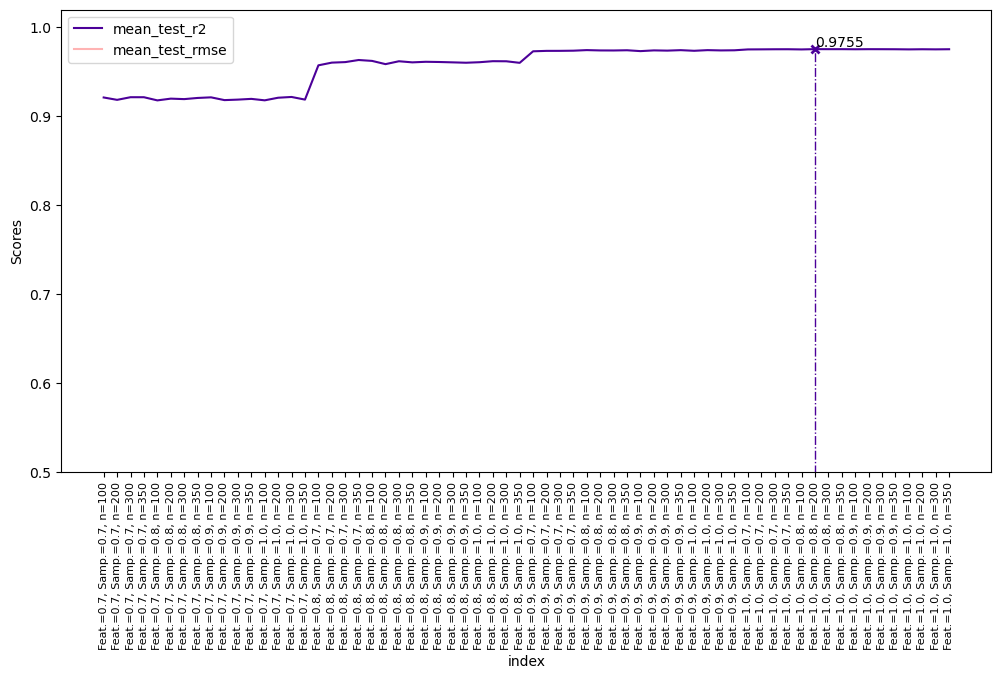

In [32]:
name_scores = ['r2']
colors = ["#4C0099", "#FFB3B3"]

data = pd.DataFrame(results)
data = data[['param_max_features', 'param_max_samples', 'param_n_estimators', 'mean_test_r2', 'rank_test_r2']]
labels = [f'max_features={i}, max_samples={j}, n_estim={k}' for i,j,k in zip(data['param_max_features'],data['param_max_samples'],data['param_n_estimators'])]
fig, ax= plt.subplots(figsize = (12,6))

ax.set_ylim(0.5, 1.02)
ax = sns.lineplot(data = data[['mean_test_r2']], palette=colors , dashes=False)
ax.set_xlabel("index")
ax.set_ylabel("Scores")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90, multialignment="left", fontsize=8)

for scorer, color in zip(name_scores,colors):
    best_index = np.nonzero(data["rank_test_%s" % scorer] == 1)[0][0]
    best_score = data["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [best_index, best_index],
        [0, best_score],
        linestyle="-.",
        linewidth=1,
        color=color,
        marker="x",
        markeredgewidth=2,
        ms=6,
    )
    ax.annotate("%0.4f" % best_score, (best_index, best_score + 0.003))

The plot above has the goal of showing how the accuracy of the model (```R2```) varies according to the parameters we have chosen. 

For what we can see here, the most important parameter is ```max_features``` once the remarcables jumps in performance of the model comes after changes in the values of this parameter. 
We can also notice that after ```max_features``` reaches the value of ```0.9``` few or any modifications happens in the model's performance. 

Aiming to represent the predictions of the model compared with to true values of labels, we divide the data set in **train** and **test** data. With the **train** set we train the model and after predict the values of ```y```. After that we plot the predicted values faced to the true values, to see if the prediction is fair in a data set never seen by the model. 

In [34]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_oh, y_Nnorm, test_size=0.33, random_state=42)

clf = grid.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Accuracy (```R2```) to the data set never seen by the model:

In [49]:
from sklearn.metrics import r2_score

r2 = r2_score(y_pred=y_pred, y_true=y_test)
print("R2: ", r2)

R2:  0.9670255022883977


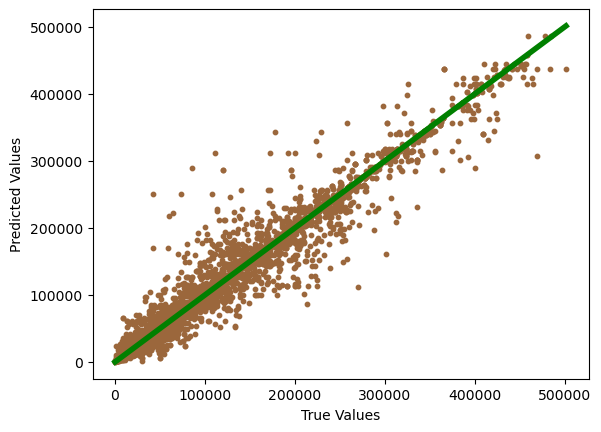

In [46]:
plt.scatter(y_test, y_pred,s=10,color='#9B673C')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Bagging regressor Evaluation')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='green', linewidth = 4)
plt.show()

As we can see, the points are close to this "identity line", which represents a equality between x and y (y = x), and therefore an equality between the predicted values and true values.

## Random Forest

We will do the same steps to the ```Random Forest``` model, with a slightly difference. Here we start using another function in the sklearn library, ```RandomizedSearchCV()```.

This function selects a random combination of the grid parameters we will set at a defined number of times (defined by us). This allows us to increase the amount of parameters tested, but still keep a reasonable calculation time. We can also test the sensibility of the model to changes in parameters. If a parameter does not vary the accuracy of the model it is not worth to explore it a lot, like this we can also reduce the calculation time.

In [45]:
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

parameters = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [50, 100, 200]
 }

metrics = {'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'}
kf = KFold(n_splits=5, shuffle=True)
random_grid = RandomizedSearchCV(RandomForestRegressor(), param_distributions=parameters, scoring=metrics, cv=kf, verbose=3, refit='r2', n_jobs=-1, n_iter=40)

random_grid.fit(X_oh, y_Nnorm)
results = random_grid.cv_results_

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 2/5] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200; r2: (test=0.751) rmse: (test=-42950.326) total time=   7.8s
[CV 1/5] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200; r2: (test=0.739) rmse: (test=-42415.338) total time=   8.2s
[CV 3/5] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200; r2: (test=0.733) rmse: (test=-44200.248) total time=   8.3s
[CV 4/5] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200; r2: (test=0.742) rmse: (test=-43379.245) total time=   9.6s
[CV 5/5] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200; r2: (test=0.751) rmse: (test=-42251.812) total time=  10.2s
[CV 3/5] END bootstrap=True, max_depth=100, max_features=None, min_samples_split=10, n_estimators=100; r2: (test=0.973) rmse: (test=-

The following code aimes to show the mean accuracy of the model each time a given parameter appears, so than we can see which parameters resulted in best performance and which it is not worth to explore

In [149]:
dic_res = {}
for i, j in zip(results['params'], results['mean_test_r2']):
    i = str(i)
    dic = {i: j}
    dic_res.update(dic)

param = list(parameters.keys())
# print(param)

param_grid = []
for p in param:
    values = parameters[p]
    for v in values:
        if v in ['sqrt', 'log2']:
            str_ = "'" + p + "'" + ': ' + "'" + str(v) + "'"
        else:
            str_ = "'" + p + "'" + ': ' + str(v)
        param_grid.append(str_)

dic_levels = {}
l = []
for level in param_grid:
    for key in list(dic_res.keys()):
        if level in key:
            l.append(dic_res[key])
    dic_levels.update({level: np.array(l)})
    l = []

# print(dic_levels)

medias_por_chave = {}

# Calcular a média para cada chave e adicionar ao novo dicionário
for chave, array in dic_levels.items():
    media = np.mean(array)
    sd = np.std(array)
    medias_por_chave[chave] = [media, sd]

# Exibir o dicionário com as médias
medias_por_chave.update({"mes": ['mean', 'std']})
df_levels = pd.DataFrame(medias_por_chave).set_index('mes').T
df_levels = df_levels.sort_values(by='mean', ascending=False)
df_levels

mes,mean,std
'max_depth': 80,0.973535,0.001301
'max_depth': 100,0.972284,0.002136
'max_depth': 50,0.972181,0.000468
'max_depth': 60,0.971715,0.000992
'max_depth': None,0.971210,0.002737
'max_depth': 70,0.969799,0.002442
'max_depth': 90,0.968820,0.003397
'max_depth': 30,0.967763,0.006711
'max_depth': 40,0.967307,0.002306
'min_samples_split': 10,0.966068,0.020852


As we can see, ```max_depth``` is important to the model, but varying its value does not change significantly the accuracy of the model. It is enough to test some values of it (the ones that resulted in best values of accuracy), but not to do an extensive research in this parameter.

For ```min_samples_split``` equals to 5 or 10 the model has a good performance, but when it is equals to 2, the performance is way lower. A similar thing happens to ```n_estimators```.

For ```bootstrap``` we see that the value ```False``` results better accuracy. And the same thing to ```max_features``` with the value ```None```.

Knowing these informations, we adapt a ```GridSearchCV()``` to our data.

In [30]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

parameters = {
    'bootstrap': [False],
    'max_depth': [50, 60, 80, 100],
    'max_features': [None],          # after selecting the range of parameters that had the
    'min_samples_split': [5, 10],    # best performance in the previous analysis
    'n_estimators': [50, 100]
}

metrics = {'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'}
kf = KFold(n_splits=5, shuffle=True)
grid = GridSearchCV(RandomForestRegressor(), param_grid=parameters, scoring=metrics, cv=kf, verbose=2, refit='r2', n_jobs=-1)

grid.fit(X_oh, y_Nnorm)
results = grid.cv_results_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_split=10, n_estimators=50; total time=  30.1s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_split=5, n_estimators=50; total time=  30.9s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_split=5, n_estimators=50; total time=  32.1s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_split=5, n_estimators=50; total time=  35.9s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_split=10, n_estimators=50; total time=  36.7s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_split=5, n_estimators=50; total time=  37.8s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_split=5, n_estimators=50; total time=  45.7s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_split=10, n_estimators=50; total time=  31.5s
[CV] END

In [31]:
grid.best_estimator_

RandomForestRegressor(bootstrap=False, max_depth=50, max_features=None,
                      min_samples_split=10, n_estimators=50)

In order to know the performance of the best model found by ```Grid Search``` we perform a cross validation in our data and calculate the metrics

In [36]:
clf = grid.best_estimator_
scoring = ['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
kf = KFold(n_splits=5, shuffle=True)
res = cross_validate(clf, X_oh, y_Nnorm, cv=kf, scoring=scoring)
print('R2: ', res['test_r2'].mean())
print('RMSE: ', res['test_neg_root_mean_squared_error'].mean()*-1)

R2:  0.9684820280767955
RMSE:  15071.39156860265


/home/afonso/miniconda3/envs/yield_prediction/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/afonso/miniconda3/envs/yield_prediction/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/afonso/miniconda3/envs/yield_prediction/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/afonso/miniconda3/envs/yield_prediction/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

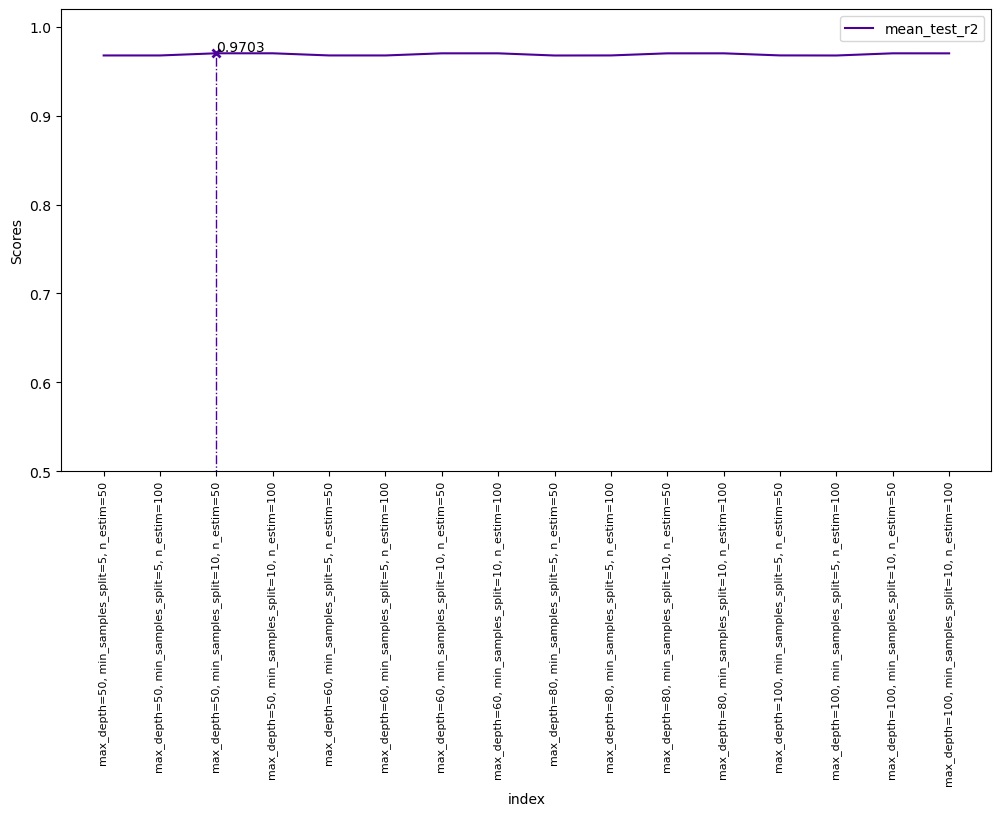

In [40]:
name_scores = ['r2']
colors = ["#4C0099", "#FFB3B3"]

data = pd.DataFrame(results)
data = data[['param_max_depth', 'param_min_samples_split', 'param_n_estimators', 'mean_test_r2', 'rank_test_r2']]
labels = [f'max_depth={i}, min_samples_split={j}, n_estim={k}' for i,j,k in zip(data['param_max_depth'],data['param_min_samples_split'],data['param_n_estimators'])]
fig, ax= plt.subplots(figsize = (12,6))

ax.set_ylim(0.5, 1.02)
ax = sns.lineplot(data = data[['mean_test_r2']], palette=colors , dashes=False)
ax.set_xlabel("index")
ax.set_ylabel("Scores")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90, multialignment="left", fontsize=8)

for scorer, color in zip(name_scores,colors):
    best_index = np.nonzero(data["rank_test_%s" % scorer] == 1)[0][0]
    best_score = data["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [best_index, best_index],
        [0, best_score],
        linestyle="-.",
        linewidth=1,
        color=color,
        marker="x",
        markeredgewidth=2,
        ms=6,
    )
    ax.annotate("%0.4f" % best_score, (best_index, best_score + 0.003))

We can see the few or any changes happens to the accuracy of the model when we vary its parameters.

In [41]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_oh, y_Nnorm, test_size=0.33, random_state=42)

clf = grid.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [42]:
from sklearn.metrics import r2_score

r2 = r2_score(y_pred=y_pred, y_true=y_test)
print("R2: ", r2)

0.9670255022883977

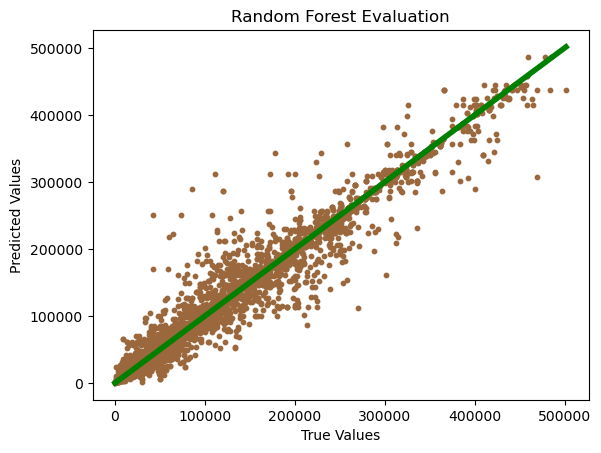

In [45]:
plt.scatter(y_test, y_pred,s=10,color='#9B673C')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Evaluation')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='green', linewidth = 4)
plt.show()

We get the same conclusion as the ```Bagging``` model.

# Model retained and conclusions

The performance of both models are great given the regression problem we have. The predictions of both models are fair compared to the real values.

However, the ```Bagging``` model has a slighthly higher accuracy score and therefore it is the model we retain.

It was shown that the preprocessing of data (encoding of categorical data and normalization of numeric attibuts) had the higher impact in the performance of the model. The hyperparameters tuning has a great impact, but many values were redundant. 

For future tuning in the model we would suggest to try other practices of preprocessing data and even feature engineering. This could have a strong impact in the performance of predictions.